In [8]:
#!/usr/bin/env python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
import importlib
import os
# 1. Imports from my existing pipeline
import config
importlib.reload(config)
from config import BIN_SIZE, STRATIFY_BY, ANALYSIS_MODE

import helper_functions
importlib.reload(helper_functions)
from helper_functions import get_stable_pipeline, preprocess_data

In [ ]:
# Configuration
MODEL_PATH = 'final_lasso_model.joblib'
FEATURES_PATH = 'model_features.joblib'
HOLDOUT_MATRIX_PATH = "/labmed/workspace/lotta/finaletoolkit/ba_analysis_scripts/holdout_preprocessing/results/final_feature_matrix_gc_corrected_50000.tsv"
BIN_SIZE = 50000

print("--- Final Holdout Validation ---")

--- Final Holdout Validation ---


In [10]:
model = joblib.load(MODEL_PATH)
# 2. Jetzt kannst du die Parameter auslesen:
print(f"Modell erfolgreich geladen: {model}")
# Den C-Wert aus der stabilen Pipeline holen
# (Wir gehen in den Schritt 'stable_model')
c_wert = model.named_steps['stable_model'].C
print(f"Der verwendete C-Wert (c_1se) ist: {c_wert}")

Modell erfolgreich geladen: Pipeline(steps=[('scaler', StandardScaler()),
                ('stable_model',
                 LogisticRegression(C=16.768329368110066, max_iter=10000,
                                    penalty='l1', random_state=42,
                                    solver='liblinear'))])
Der verwendete C-Wert (c_1se) ist: 16.768329368110066


In [11]:
# 1. Die gesamte Struktur anzeigen
print("Modell Struktur:")
print(model)

# 2. Nur das Modell innerhalb der Pipeline ansprechen (der letzte Schritt)
model_step = model.named_steps['stable_model']

# 3. Den C-Wert und andere Hyperparameter auslesen
print("\n--- Modell Parameter ---")
print(f"Gewählter C-Wert (c_1se): {model_step.C}")
print(f"Penalty (Lasso/Ridge):   {model_step.penalty}")
print(f"Solver:                  {model_step.solver}")

# 4. Falls du sehen willst, wie viele Koeffizienten NICHT null sind (Relevante Bins)
n_features = np.sum(model_step.coef_ != 0)
print(f"Anzahl relevanter Bins:  {n_features} von {len(model_features)}")


Modell Struktur:
Pipeline(steps=[('scaler', StandardScaler()),
                ('stable_model',
                 LogisticRegression(C=16.768329368110066, max_iter=10000,
                                    penalty='l1', random_state=42,
                                    solver='liblinear'))])

--- Modell Parameter ---
Gewählter C-Wert (c_1se): 16.768329368110066
Penalty (Lasso/Ridge):   l1
Solver:                  liblinear
Anzahl relevanter Bins:  403 von 12780


In [12]:
# 1. Check if model files exist
if not os.path.exists(MODEL_PATH) or not os.path.exists(FEATURES_PATH):
    print(f"ERROR: Model or Feature list not found!")
    print(f"Please run the following in your Training Notebook (04):")
    print(f"  joblib.dump(stable_pipeline, 'final_lasso_model.joblib')")
    print(f"  joblib.dump(X_train.columns.tolist(), 'model_features.joblib')")
    exit(1)

In [13]:
# 2. Load the stored Model and Feature names
print("Loading saved pipeline and features...")
model = joblib.load(MODEL_PATH)
model_features = joblib.load(FEATURES_PATH)

# Detect which metrics are needed (e.g., 'mean', 'median', 'stdev' detected from feature names)
# Feature names in the model look like 'mean_chr1_900000'
needed_metrics = list(set([f.split('_chr')[0] for f in model_features]))
print(f"Metrics required by model: {needed_metrics}")

Loading saved pipeline and features...
Metrics required by model: ['mean', 'median', 'stdev']


In [14]:
# 3. Load Holdout Data
print("Loading holdout matrix...")
if not os.path.exists(HOLDOUT_MATRIX_PATH):
    print(f"ERROR: Holdout matrix not found at {HOLDOUT_MATRIX_PATH}")
    exit(1)

df_holdout = pd.read_csv(HOLDOUT_MATRIX_PATH, sep="\t")

Loading holdout matrix...


In [15]:
# 4. Prepare Holdout Features (Pivoting)
print("Formatting holdout features to match model structure...")
# Add bin_id (format chrom_start) like in your helper_functions
df_holdout["bin_id"] = df_holdout["chrom"] + "_" + df_holdout["start"].astype(str)

# Pivot the long-format holdout data into the wide format the model expects
X_holdout_raw = df_holdout.pivot(index="sample", columns="bin_id", values=needed_metrics)

# Flatten columns to match 'metric_chrom_start' (e.g., 'mean_chr1_900000')
X_holdout_raw.columns = [f"{m}_{bid}" for m, bid in X_holdout_raw.columns]

# IMPORTANT: Align columns with the model features (handle missing bins and order)
X_holdout = X_holdout_raw.reindex(columns=model_features, fill_value=0)
print(f"Feature alignment complete. Shape: {X_holdout.shape}")

Formatting holdout features to match model structure...
Feature alignment complete. Shape: (30, 12780)


In [16]:
# 5. Extract Ground Truth (y_holdout)
# We use the 'group' column which contains the folder names (healthy, pancreatic, etc.)
group_info = df_holdout[['sample', 'group']].drop_duplicates().set_index('sample')
# 1 if cancer, 0 if healthy
y_holdout = (group_info.loc[X_holdout.index, "group"].str.lower() != "healthy").astype(int).values


In [17]:
# 6. Prediction
print(f"Running prediction on {len(X_holdout)} samples...")
probs = model.predict_proba(X_holdout)[:, 1]

Running prediction on 30 samples...


In [18]:
# 7. Evaluation (AUC Score)
auc_score = roc_auc_score(y_holdout, probs)
print(f"\n" + "="*40)
print(f"🔥 FINAL HOLDOUT AUC: {auc_score:.4f}")
print("="*40 + "\n")


🔥 FINAL HOLDOUT AUC: 0.4489



In [19]:
# 8. Save Results
output_dir = "holdout_preprocessing/results"
os.makedirs(output_dir, exist_ok=True)
results_df = pd.DataFrame({
    'sample': X_holdout.index,
    'prediction_score': probs,
    'true_label': y_holdout
})
results_df.to_csv(f"{output_dir}/holdout_validation_results.csv", index=False)


FileNotFoundError: [Errno 2] No such file or directory: 'holdout_preprocessing/plots/holdout_final_roc_joblib.png'

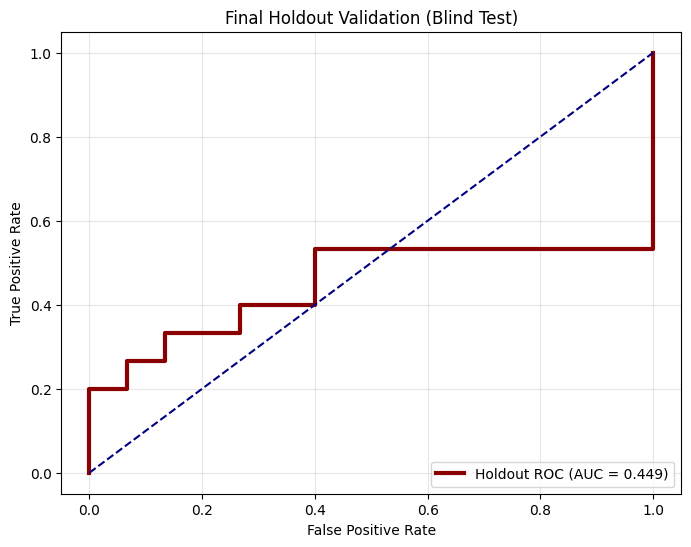

In [20]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_holdout, probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkred', lw=3, label=f'Holdout ROC (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final Holdout Validation (Blind Test)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig("holdout_preprocessing/plots/holdout_final_roc_joblib.png")
print("Detailed results and plots saved in 'holdout_preprocessing/'.")